In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import numpy as np
# from tqdm import tqdm
# import os
import matplotlib.pyplot as plt
import cv2
from gait import preprocess
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
from utils import angle_ims, get_device, simple_mean

In [41]:
class Fake(nn.Module):

    '''
    Performs 3D convolution
    '''

    def __init__(self):

        super(Fake, self).__init__()
        self.conv1 = self._convblock(1,16,3,1,False)
        self.conv2 = self._convblock(16,32,1,1,False)
        self.conv3 = self._convblock(32,16,1,1,False)
        self.conv4 = self._convblock(16,1,1,1,True)

    def _convblock(self,in_channels,out_channels,ksized,ksize,last):
        '''
        Makes a block of layers (Conv3d,ReLU,Maxpool3d,BatchNorm3d(only if !last))
        '''

        l1 = nn.Conv3d(in_channels=in_channels,out_channels=out_channels,kernel_size=(ksized,ksize,ksize))
        l2 = nn.ReLU()
        
        if last:
            return nn.Sequential(l1,l2)
        else:
            l3 = nn.MaxPool3d((1, 1, 1))
            l4 = nn.BatchNorm3d(out_channels)
            return nn.Sequential(l1,l2,l3,l4)
        
        
    def forward(self,x):

        out = self.conv1(x)
        print(out.shape)
        out = self.conv2(out)
        print(out.shape)
        out = self.conv3(out)
        print(out.shape)
        out = self.conv4(out)
        print(out.shape)
        
        return out


In [2]:
class Conv3D(nn.Module):

    '''
    Performs 3D convolution
    '''

    def __init__(self):

        super(Conv3D, self).__init__()
        self.conv1 = self._convblock(1,16,3,1,False)
        self.conv2 = self._convblock(16,32,1,1,False)
        self.conv3 = self._convblock(32,16,1,1,False)
        self.conv4 = self._convblock(16,1,1,1,True)

    def _convblock(self,in_channels,out_channels,ksized,ksize,last):
        '''
        Makes a block of layers (Conv3d,ReLU,Maxpool3d,BatchNorm3d(only if !last))
        '''

        l1 = nn.Conv3d(in_channels=in_channels,out_channels=out_channels,kernel_size=(ksized,ksize,ksize))
        l2 = nn.ReLU()
        
        if last:
            return nn.Sequential(l1,l2)
        else:
            l3 = nn.MaxPool3d((1, 1, 1))
            l4 = nn.BatchNorm3d(out_channels)
            return nn.Sequential(l1,l2,l3,l4)
        
        
    def forward(self,x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        return out


In [49]:
model = Conv3D()
device = get_device()
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()

In [4]:
class PEI(Dataset):

    def __init__(self, num_exps,transform=None):
        """
        Custom dataset for images of a certain keypose at a given angle.

        Args:
            angle (int)     : Angle
            keypose (int)   : Key-pose/Cluster
            data_path (str) : Path where dataset is downloaded
        """
        
        self.ds = [] #Paths to all images d[0]=> subject 1  (len = num of frames for it)
        for i in range(num_exps):
            exp = angle_ims(exp=i+1,angle=0,keypose = 4)
            self.ds = self.ds + exp

        

    def __len__(self):

        return len(self.ds)

    def __getitem__(self, idx):

        frames = np.asarray([preprocess(cv2.imread(im))/255. for im in self.ds[idx]])
        y = np.mean([image for image in frames],axis=0)
        
        
        return frames.reshape(1,frames.shape[0],frames.shape[1],frames.shape[2]).astype('float32'),y.astype('float32')

In [5]:
data = PEI(10)

In [7]:
dl = DataLoader(data,batch_size=1)

## Training

In [46]:
#Loss
criterion = nn.MSELoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# y = torch.from_numpy(simple_mean(angle=0,cluster=4)).to(device,dtype=torch.float)

In [47]:
#Epochs
n_epochs = 7

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images,y in dl:
        images,y = images.cuda(), y.cuda()
        optimizer.zero_grad()

        out = model(images)
        temp_out = torch.reshape(out, (out.shape[0],out.shape[3],out.shape[4]))
        loss = criterion(temp_out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
          
    train_loss = train_loss/len(dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.024481
Epoch: 2 	Training Loss: 0.002151
Epoch: 3 	Training Loss: 0.001438
Epoch: 4 	Training Loss: 0.001329
Epoch: 5 	Training Loss: 0.001227
Epoch: 6 	Training Loss: 0.001200
Epoch: 7 	Training Loss: 0.001156


In [18]:
torch.cuda.empty_cache()

## CHECK

In [19]:
def ims(img):
    plt.imshow(np.transpose(img, (1, 2, 0)),cmap='gray',vmax=1) 

### 10 exps (i.e, 53*3 = 159 images)

In [21]:
len(data)

53

(3, 160, 120)


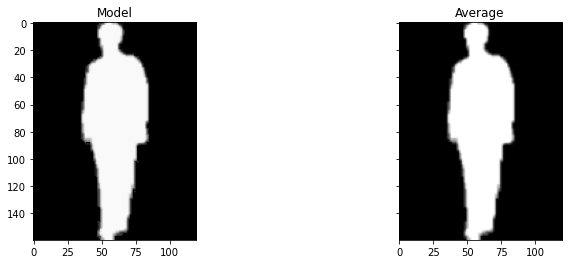

In [48]:
dataiter = iter(dl)
images,_ = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
# print(type(images),images.shape)

#Sample outputs
output = model(images.to(device=device))
images = images.cpu().numpy().reshape(3,160,120)
output = output.view(160, 120)
output = output.cpu().detach().numpy()
out = np.mean([image for image in images],axis=0)
print(images.shape)

#Reconstructed Images
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4))
axes[0].imshow(output,cmap='gray',vmin=0,vmax=1)
axes[0].set_title('Model')
axes[1].imshow(out,cmap='gray',vmin=0,vmax=1)
axes[1].set_title('Average')
plt.show() 
# plt.show() 